# Implementation of DLRM (Full/Faktor 2/APFL) 

## Imports

In [1]:
SYFT_VERSION = ">=0.8.2.b0,<0.9"
package_string = f'"syft{SYFT_VERSION}"'
# %pip install {package_string} -q

import tensorflow as tf
from tensorflow.keras.metrics import AUC
# syft absolute
import syft as sy

sy.requires(SYFT_VERSION)

import pandas as pd
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/alex


✅ The installed version of syft==0.8.4 matches the requirement >=0.8.2b0 and the requirement <0.9


## Load and preprocess the data

In [2]:
# Load the dataset and fill the nan with 0
columns = ['label', *(f'I{i}' for i in range(1, 14)), *(f'C{i}' for i in range(1, 27))]
df = pd.read_csv('/Users/alex/Thesis/New Dataset/train.txt', sep='\t', names=columns).fillna(0)
df

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,1.0,1,5.0,0.0,1382.0,4.0,15.0,2.0,181.0,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,0,3a171ecb,c5c50484,e8b83407,9727dd16
1,0,2.0,0,44.0,1.0,102.0,8.0,2.0,2.0,4.0,...,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,0,3a171ecb,43f13e8b,e8b83407,731c3655
2,0,2.0,0,1.0,14.0,767.0,89.0,4.0,2.0,245.0,...,8efede7f,3412118d,0,0,e587c466,ad3062eb,3a171ecb,3b183c5c,0,0
3,0,0.0,893,0.0,0.0,4392.0,0.0,0.0,0.0,0.0,...,1e88c74f,74ef3502,0,0,6b3a5ca6,0,3a171ecb,9117a34a,0,0
4,0,3.0,-1,0.0,0.0,2.0,0.0,3.0,0.0,0.0,...,1e88c74f,26b3c7a7,0,0,21c9516a,0,32c7478e,b34f3128,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1364724,0,0.0,2,0.0,2.0,41171.0,90.0,0.0,2.0,47.0,...,07c540c4,ab194a92,0,0,21c9516a,0,32c7478e,b34f3128,0,0
1364725,0,0.0,3,7.0,10.0,3912.0,400.0,2.0,17.0,104.0,...,e5ba7672,698d1c68,0,0,08119c8b,0,32c7478e,f96a556f,0,0
1364726,0,0.0,1,48.0,0.0,17375.0,0.0,0.0,0.0,0.0,...,e5ba7672,7b06fafe,2f4b9dd2,a458ea53,033d948f,0,32c7478e,226b0ab6,2bf691b1,9aed84e6
1364727,0,0.0,0,49.0,2.0,16610.0,0.0,0.0,6.0,0.0,...,1e88c74f,c21c3e4c,efa3470f,a458ea53,d3563291,0,bcdee96c,f88869fd,9b3e8820,86fe1bbe


In [3]:
# Preprocess Dense Features
dense_cols = [c for c in columns if 'I' in c]
df[dense_cols] = preprocessing.StandardScaler().fit_transform(df[dense_cols])
df

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,-0.126764,-0.267956,-0.039644,-0.661748,-0.250526,-0.228230,0.020912,-0.391033,0.389777,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,0,3a171ecb,c5c50484,e8b83407,9727dd16
1,0,0.018618,-0.270689,0.104480,-0.536490,-0.269520,-0.217521,-0.208636,-0.391033,-0.454746,...,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,0,3a171ecb,43f13e8b,e8b83407,731c3655
2,0,0.018618,-0.270689,-0.054426,1.091864,-0.259652,-0.000653,-0.173320,-0.391033,0.695141,...,8efede7f,3412118d,0,0,e587c466,ad3062eb,3a171ecb,3b183c5c,0,0
3,0,-0.272146,2.170260,-0.058121,-0.661748,-0.205861,-0.238940,-0.243951,-0.460362,-0.473831,...,1e88c74f,74ef3502,0,0,6b3a5ca6,0,3a171ecb,9117a34a,0,0
4,0,0.164000,-0.273423,-0.058121,-0.661748,-0.271004,-0.238940,-0.190978,-0.460362,-0.473831,...,1e88c74f,26b3c7a7,0,0,21c9516a,0,32c7478e,b34f3128,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1364724,0,-0.272146,-0.265222,-0.058121,-0.411232,0.339901,0.002024,-0.243951,-0.391033,-0.249579,...,07c540c4,ab194a92,0,0,21c9516a,0,32c7478e,b34f3128,0,0
1364725,0,-0.272146,-0.262489,-0.032253,0.590832,-0.212983,0.832010,-0.208636,0.128934,0.022386,...,e5ba7672,698d1c68,0,0,08119c8b,0,32c7478e,f96a556f,0,0
1364726,0,-0.272146,-0.267956,0.119262,-0.661748,-0.013207,-0.238940,-0.243951,-0.460362,-0.473831,...,e5ba7672,7b06fafe,2f4b9dd2,a458ea53,033d948f,0,32c7478e,226b0ab6,2bf691b1,9aed84e6
1364727,0,-0.272146,-0.270689,0.122957,-0.411232,-0.024558,-0.238940,-0.243951,-0.252375,-0.473831,...,1e88c74f,c21c3e4c,efa3470f,a458ea53,d3563291,0,bcdee96c,f88869fd,9b3e8820,86fe1bbe


In [4]:
# Preprocess Categorical Features
cat_cols = [c for c in columns if 'C' in c]
mappings = {
    col: dict(zip(values, range(len(values))))
    for col, values in map(lambda col: (col, df[col].unique()), cat_cols)
}
for col, mapping in mappings.items():
    df[col] = df[col].map(mapping.get)
df

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,-0.126764,-0.267956,-0.039644,-0.661748,-0.250526,-0.228230,0.020912,-0.391033,0.389777,...,0,0,0,0,0,0,0,0,0,0
1,0,0.018618,-0.270689,0.104480,-0.536490,-0.269520,-0.217521,-0.208636,-0.391033,-0.454746,...,1,1,0,1,1,0,0,1,0,1
2,0,0.018618,-0.270689,-0.054426,1.091864,-0.259652,-0.000653,-0.173320,-0.391033,0.695141,...,2,2,1,2,2,1,0,2,1,2
3,0,-0.272146,2.170260,-0.058121,-0.661748,-0.205861,-0.238940,-0.243951,-0.460362,-0.473831,...,3,3,1,2,3,0,0,3,1,2
4,0,0.164000,-0.273423,-0.058121,-0.661748,-0.271004,-0.238940,-0.190978,-0.460362,-0.473831,...,3,4,1,2,4,0,1,4,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1364724,0,-0.272146,-0.265222,-0.058121,-0.411232,0.339901,0.002024,-0.243951,-0.391033,-0.249579,...,1,246,1,2,4,0,1,4,1,2
1364725,0,-0.272146,-0.262489,-0.032253,0.590832,-0.212983,0.832010,-0.208636,0.128934,0.022386,...,0,21,1,2,144,0,1,20,1,2
1364726,0,-0.272146,-0.267956,0.119262,-0.661748,-0.013207,-0.238940,-0.243951,-0.460362,-0.473831,...,0,88,96,3,315255,0,1,2096,11,5419
1364727,0,-0.272146,-0.270689,0.122957,-0.411232,-0.024558,-0.238940,-0.243951,-0.252375,-0.473831,...,3,49,73,3,315256,0,8,29121,3,22213


In [5]:
label_counts = df.groupby('label')['I1'].count()
print(f'Baseline: {max(label_counts.values) / sum(label_counts.values) * 100}%')

Baseline: 74.63203317288634%


In [6]:
# Select halfway point for the split
split_point = len(df) // 2

# Amplify integer features in the first half by multiplying by 2
df.loc[:split_point, 'I1':'I13'] *= 2

# Dampen those integer features in the second half by dividing by 2
df.loc[split_point:, 'I1':'I13'] /= 2

# Now split the DataFrame into two parts: one with amplified features and one with dampened features
df1 = df.iloc[:split_point].reset_index(drop=True)
df2 = df.iloc[split_point:].reset_index(drop=True)

# Verifying the manipulation
print(f"Total records: {len(df)}")
print(f"df1 records: {len(df1)} - with amplified features")
print(f"df2 records: {len(df2)} - with dampened features")

Total records: 1364729
df1 records: 682364 - with amplified features
df2 records: 682365 - with dampened features


In [7]:
dense_cols = [c for c in df.columns if 'I' in c]
cat_cols = [c for c in df.columns if 'C' in c]
fixed_embedding_size = 455000
emb_counts = [len(df[c].unique()) for c in cat_cols]

## Data Owner 1

In [8]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df1)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df1[dense_cols].values, tf.float32),
        tf.cast(df1[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df1['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [9]:
def MLP(arch, activation='relu', out_activation=None):
    mlp = tf.keras.Sequential()

    for units in arch[:-1]:
        mlp.add(tf.keras.layers.Dense(units, activation=activation))

    mlp.add(tf.keras.layers.Dense(arch[-1], activation=out_activation))

    return mlp


class SecondOrderFeatureInteraction(tf.keras.layers.Layer):
    def __init__(self, self_interaction=False):
        super(SecondOrderFeatureInteraction, self).__init__()
        self.self_interaction = self_interaction

    def call(self, inputs):
        batch_size = tf.shape(inputs[0])[0]
        concat_features = tf.stack(inputs, axis=1)

        dot_products = tf.matmul(concat_features, concat_features, transpose_b=True)

        ones = tf.ones_like(dot_products)
        mask = tf.linalg.band_part(ones, 0, -1)
        out_dim = int(len(inputs) * (len(inputs) + 1) / 2)

        if not self.self_interaction:
            mask = mask - tf.linalg.band_part(ones, 0, 0)
            out_dim = int(len(inputs) * (len(inputs) - 1) / 2)

        flat_interactions = tf.reshape(tf.boolean_mask(dot_products, mask), (batch_size, out_dim))
        return flat_interactions


class DLRM(tf.keras.Model):
    def __init__(
            self,
            embedding_sizes,
            embedding_dim,
            arch_bot,
            arch_top,
            self_interaction,
    ):
        super(DLRM, self).__init__()
        self.emb = [tf.keras.layers.Embedding(size, embedding_dim) for size in embedding_sizes]
        self.bot_nn = MLP(arch_bot, out_activation='relu')
        self.top_nn = MLP(arch_top, out_activation='sigmoid')
        self.interaction_op = SecondOrderFeatureInteraction(self_interaction)

    def call(self, input):
        input_dense, input_cat = input
        emb_x = [E(x) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
        dense_x = self.bot_nn(input_dense)

        Z = self.interaction_op(emb_x + [dense_x])
        z = tf.concat([dense_x, Z], axis=1)
        p = self.top_nn(z)

        return p

In [10]:
model = DLRM(
    embedding_sizes=emb_counts,
    embedding_dim=2,
    arch_bot=[8, 2],
    arch_top=[128, 64, 2],
    self_interaction=False
)

model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', AUC(name='auc')]  
)

In [11]:
BATCH_SIZE = 128

history =model.fit(
    ds_train.batch(BATCH_SIZE),
    validation_data=ds_valid.batch(BATCH_SIZE),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
    ],
    epochs=5,
    verbose=1,
)


Epoch 1/5
4265/4265 [==============================] - 131s 29ms/step - loss: 0.5188 - accuracy: 0.7584 - auc: 0.8219 - val_loss: 0.4883 - val_accuracy: 0.7704 - val_auc: 0.8451
Epoch 2/5
4265/4265 [==============================] - 216s 51ms/step - loss: 0.4659 - accuracy: 0.7815 - auc: 0.8606 - val_loss: 0.4814 - val_accuracy: 0.7715 - val_auc: 0.8504
Epoch 3/5
4265/4265 [==============================] - 340s 80ms/step - loss: 0.4351 - accuracy: 0.7998 - auc: 0.8801 - val_loss: 0.4916 - val_accuracy: 0.7672 - val_auc: 0.8460
Epoch 4/5
4265/4265 [==============================] - 384s 90ms/step - loss: 0.4040 - accuracy: 0.8179 - auc: 0.8978 - val_loss: 0.5092 - val_accuracy: 0.7619 - val_auc: 0.8379
Epoch 5/5
4265/4265 [==============================] - 391s 92ms/step - loss: 0.3752 - accuracy: 0.8329 - auc: 0.9125 - val_loss: 0.5295 - val_accuracy: 0.7601 - val_auc: 0.8332


In [12]:
model.summary()

Model: "dlrm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  2632      
                                                                 
 embedding_1 (Embedding)     multiple                  1066      
                                                                 
 embedding_2 (Embedding)     multiple                  849010    
                                                                 
 embedding_3 (Embedding)     multiple                  303040    
                                                                 
 embedding_4 (Embedding)     multiple                  558       
                                                                 
 embedding_5 (Embedding)     multiple                  32        
                                                                 
 embedding_6 (Embedding)     multiple                  22222  

In [13]:
results = model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

853/853 [==============================] - 35s 21ms/step - loss: 0.5408 - accuracy: 0.7549 - auc: 0.8274
Loss: 0.5407751798629761, Accuracy: 0.7549070715904236, AUC: 0.8274296522140503


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.518821,0.758433,0.821884,0.488303,0.770426,0.845088
1,0.465913,0.781482,0.860584,0.481437,0.771488,0.850403
2,0.435066,0.799784,0.880081,0.491571,0.767238,0.845999
3,0.404038,0.817878,0.897753,0.509159,0.761889,0.837890
4,0.375156,0.832862,0.912532,0.529482,0.760057,0.833169


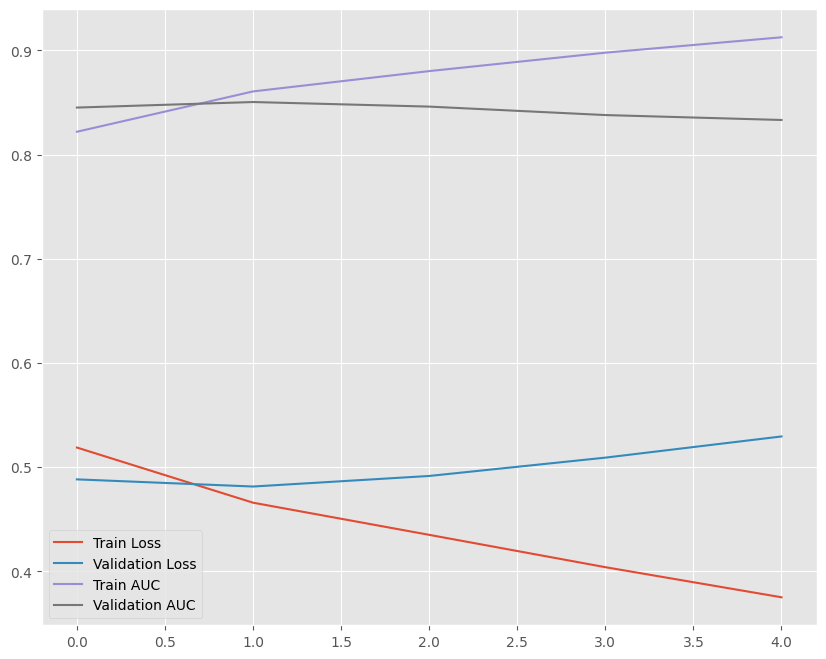

Validation AUC: 0.8325


In [14]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC 
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()

# Evaluate the model on the validation dataset
val_metrics = model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)

val_auc_index = model.metrics_names.index('auc')
auc_score_baseline1 = val_metrics[val_auc_index]

print(f"Validation AUC: {auc_score_baseline1:.4f}")

In [15]:
import numpy as np

def add_noise_to_weights(weights, noise_std=0.01):
    """Adds Gaussian noise to a dictionary of weights."""
    noisy_weights = {}
    for key, weight in weights.items():
        # Generating Gaussian noise with the same shape as the weight
        noise = np.random.normal(loc=0.0, scale=noise_std, size=weight.shape)
        # Adding the noise to the weight
        noisy_weight = weight + noise
        noisy_weights[key] = noisy_weight
    return noisy_weights

# Extract the model's weights into a dictionary
model_weights_dict_1 = {v.name: v.numpy() for v in model.trainable_variables}

# Add noise to the model's weights
noisy_model_weights_dict_1 = add_noise_to_weights(model_weights_dict_1, noise_std=0.01)

# Now, noisy_model_weights_dict contains the weights with added Gaussian noise

In [20]:
node = sy.orchestra.launch(name="test-domain-1", port="auto", dev_mode=True, reset=True)

Staging Protocol Changes...
Starting test-domain-1 server on 0.0.0.0:14776
Waiting for server to start

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/alex


.............

INFO:     Started server process [44711]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:14776 (Press CTRL+C to quit)


.
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/7bca415d13ed4ec881f0d0aede098dbb.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=0 image_uid=8a14bcaa4a3d43ba89f8648891e0bd19 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
INFO:     127.0.0.1:54287 - "GET /api/v2/metadata HTTP/1.1" 200 OK
 Done.


Login to the Domain

In [21]:
domain_client = node.login(email="info@openmined.org", password="changethis")

INFO:     127.0.0.1:54289 - "GET /api/v2/metadata HTTP/1.1" 200 OK
INFO:     127.0.0.1:54289 - "GET /api/v2/metadata HTTP/1.1" 200 OK
Logged into <test-domain-1: High-side Domain> as GUEST
INFO:     127.0.0.1:54289 - "POST /api/v2/login HTTP/1.1" 200 OK
INFO:     127.0.0.1:54289 - "GET /api/v2/api?verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f&communication_protocol=3 HTTP/1.1" 200 OK
INFO:     127.0.0.1:54294 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Logged into <test-domain-1: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

Initialize Model Weights

In [22]:
# Convert the trained model parameters to a Syft ActionObject
model_weights_obj = sy.ActionObject.from_obj(noisy_model_weights_dict_1)

# Check the object type and attributes
print(type(model_weights_obj.syft_action_data), model_weights_obj.id)


<class 'dict'> 32274385aead4bd89c01ece8e35b6264


In [23]:
# Set the model weights ActionObject in the domain
weight_domain_obj = domain_client.api.services.action.set(model_weights_obj)

# Check the domain object attributes
print(weight_domain_obj.id)


INFO:     127.0.0.1:54297 - "POST /api/v2/api_call HTTP/1.1" 200 OK
32274385aead4bd89c01ece8e35b6264


Convert Model Weights to Syft ActionObject:

Define a Weights Access function

In [24]:
@sy.syft_function(
    input_policy=sy.ExactMatch(weights=weight_domain_obj.id),
    output_policy=sy.SingleExecutionExactOutput(),
)
def fetch_weights(weights):
    # Simply return the weights; no computation needed
    return weights


INFO:     127.0.0.1:54309 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54312 - "GET /api/v2/metadata HTTP/1.1" 200 OK


SyftSuccess: Syft function 'fetch_weights' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

Access Weights

In [25]:
weights_pointer = fetch_weights(weights=weight_domain_obj)
weights_local = weights_pointer.get()

SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/a146286ae45b42fbb8c6ae34e8eb2a63.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=8a1b828d91184073830a0639182f9893 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
Logged into <ephemeral_node_fetch_weights_2246: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

INFO:     127.0.0.1:54320 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54322 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain ephemeral_node_fetch_weights_2246
SyftInfo: Landing the ephmeral node...
SyftInfo: Node Landed!


Retrieve and Verify the Output

Request and Approve Code Execution

In [26]:
request = domain_client.code.request_code_execution(fetch_weights)
request

INFO:     127.0.0.1:54380 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54382 - "GET /api/v2/api?verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f&communication_protocol=3 HTTP/1.1" 200 OK
INFO:     127.0.0.1:54384 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54386 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54389 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54391 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54393 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54395 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54397 - "POST /api/v2/api_call HTTP/1.1" 200 OK


syft.service.request.request.Request

In [27]:
request.approve()

INFO:     127.0.0.1:54382 - "GET /api/v2/metadata HTTP/1.1" 200 OK
INFO:     127.0.0.1:54399 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54401 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54405 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54407 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54409 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54411 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54415 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain test-domain-1
INFO:     127.0.0.1:54419 - "POST /api/v2/api_call HTTP/1.1" 200 OK


SyftSuccess: Request 5470e58ec5284c69bd42351960f5f12f changes applied

In [28]:
domain_client._api = None
_ = domain_client.api

INFO:     127.0.0.1:54382 - "GET /api/v2/api?verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f&communication_protocol=3 HTTP/1.1" 200 OK


Fetching the pointer and the actual weights

In [29]:
# Fetch the weights pointer from the domain
weights_ptr = fetch_weights(weights=weight_domain_obj)

# Retrieve the actual weights from the pointer
weights_local = weights_ptr.get()


SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/5e3a0b589a9c4de592cf210f2b520571.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=4a058959396f4a98862c09aad6619a66 in_memory=True
Timeout elapsed after 30 seconds while trying to acquiring lock.
FAILED TO LOCK
Timeout elapsed after 30 seconds while trying to acquiring lock.
FAILED TO LOCK
Failed to create container: Worker: syft.service.worker.worker_pool.SyftWorker,Error: Failed to acquire lock for the operation
Data Migrated to latest version !!!
Logged into <ephemeral_node_fetch_weights_5106: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

INFO:     127.0.0.1:54468 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54470 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain ephemeral_node_fetch_weights_5106
SyftInfo: Landing the ephmeral node...
SyftInfo: Node Landed!


Retrieving the Computation Result

Cleanup and Land the Node

In [30]:
if node.node_type.value == "python":
    node.land()

## Data Owner 2

In [31]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df2)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df2[dense_cols].values, tf.float32),
        tf.cast(df2[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df2['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [32]:
def MLP(arch, activation='relu', out_activation=None):
    mlp = tf.keras.Sequential()

    for units in arch[:-1]:
        mlp.add(tf.keras.layers.Dense(units, activation=activation))

    mlp.add(tf.keras.layers.Dense(arch[-1], activation=out_activation))

    return mlp


class SecondOrderFeatureInteraction(tf.keras.layers.Layer):
    def __init__(self, self_interaction=False):
        super(SecondOrderFeatureInteraction, self).__init__()
        self.self_interaction = self_interaction

    def call(self, inputs):
        batch_size = tf.shape(inputs[0])[0]
        concat_features = tf.stack(inputs, axis=1)

        dot_products = tf.matmul(concat_features, concat_features, transpose_b=True)

        ones = tf.ones_like(dot_products)
        mask = tf.linalg.band_part(ones, 0, -1)
        out_dim = int(len(inputs) * (len(inputs) + 1) / 2)

        if not self.self_interaction:
            mask = mask - tf.linalg.band_part(ones, 0, 0)
            out_dim = int(len(inputs) * (len(inputs) - 1) / 2)

        flat_interactions = tf.reshape(tf.boolean_mask(dot_products, mask), (batch_size, out_dim))
        return flat_interactions


class DLRM(tf.keras.Model):
    def __init__(
            self,
            embedding_sizes,
            embedding_dim,
            arch_bot,
            arch_top,
            self_interaction,
    ):
        super(DLRM, self).__init__()
        self.emb = [tf.keras.layers.Embedding(size, embedding_dim) for size in embedding_sizes]
        self.bot_nn = MLP(arch_bot, out_activation='relu')
        self.top_nn = MLP(arch_top, out_activation='sigmoid')
        self.interaction_op = SecondOrderFeatureInteraction(self_interaction)

    def call(self, input):
        input_dense, input_cat = input
        emb_x = [E(x) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
        dense_x = self.bot_nn(input_dense)

        Z = self.interaction_op(emb_x + [dense_x])
        z = tf.concat([dense_x, Z], axis=1)
        p = self.top_nn(z)

        return p

In [33]:
model = DLRM(
    embedding_sizes=emb_counts,
    embedding_dim=2,
    arch_bot=[8, 2],
    arch_top=[128, 64, 2],
    self_interaction=False
)

model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', AUC(name='auc')]  
)

In [34]:
BATCH_SIZE = 128

history =model.fit(
    ds_train.batch(BATCH_SIZE),
    validation_data=ds_valid.batch(BATCH_SIZE),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
    ],
    epochs=5,
    verbose=1,
)


Epoch 1/5
4265/4265 [==============================] - 505s 117ms/step - loss: 0.5053 - accuracy: 0.7647 - auc: 0.8328 - val_loss: 0.4782 - val_accuracy: 0.7778 - val_auc: 0.8527
Epoch 2/5
4265/4265 [==============================] - 145s 34ms/step - loss: 0.4609 - accuracy: 0.7848 - auc: 0.8640 - val_loss: 0.4737 - val_accuracy: 0.7784 - val_auc: 0.8557
Epoch 3/5
4265/4265 [==============================] - 110s 26ms/step - loss: 0.4327 - accuracy: 0.8014 - auc: 0.8815 - val_loss: 0.4872 - val_accuracy: 0.7721 - val_auc: 0.8481
Epoch 4/5
4265/4265 [==============================] - 298s 70ms/step - loss: 0.4036 - accuracy: 0.8182 - auc: 0.8980 - val_loss: 0.5067 - val_accuracy: 0.7653 - val_auc: 0.8399
Epoch 5/5
4265/4265 [==============================] - 566s 133ms/step - loss: 0.3764 - accuracy: 0.8324 - auc: 0.9119 - val_loss: 0.5302 - val_accuracy: 0.7576 - val_auc: 0.8302


In [35]:
model.summary()

Model: "dlrm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  2632      
                                                                 
 embedding_1 (Embedding)     multiple                  1066      
                                                                 
 embedding_2 (Embedding)     multiple                  849010    
                                                                 
 embedding_3 (Embedding)     multiple                  303040    
                                                                 
 embedding_4 (Embedding)     multiple                  558       
                                                                 
 embedding_5 (Embedding)     multiple                  32        
                                                                 
 embedding_6 (Embedding)     multiple                  22222  

In [36]:
results = model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

853/853 [==============================] - 5s 2ms/step - loss: 0.5408 - accuracy: 0.7525 - auc: 0.8249
Loss: 0.5407503843307495, Accuracy: 0.752498209476471, AUC: 0.824934720993042


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.505262,0.764659,0.832781,0.478241,0.777827,0.852652
1,0.460888,0.784809,0.863964,0.473685,0.778413,0.855686
2,0.432718,0.801448,0.881509,0.487163,0.772074,0.848095
3,0.403602,0.818156,0.897999,0.506701,0.765260,0.839949
4,0.376398,0.832408,0.911903,0.530155,0.757602,0.830241


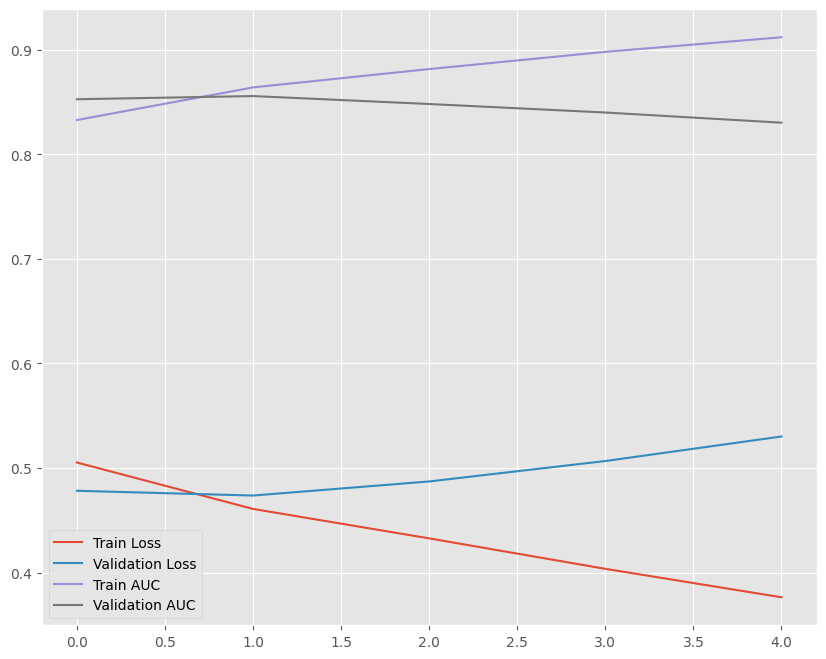

Validation AUC: 0.8297


In [37]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC 
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()

# Evaluate the model on the validation dataset
val_metrics = model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)

val_auc_index = model.metrics_names.index('auc')
auc_score_baseline2 = val_metrics[val_auc_index]

print(f"Validation AUC: {auc_score_baseline2:.4f}")

In [38]:
import numpy as np

def add_noise_to_weights(weights, noise_std=0.01):
    """Adds Gaussian noise to a dictionary of weights."""
    noisy_weights = {}
    for key, weight in weights.items():
        # Generating Gaussian noise with the same shape as the weight
        noise = np.random.normal(loc=0.0, scale=noise_std, size=weight.shape)
        # Adding the noise to the weight
        noisy_weight = weight + noise
        noisy_weights[key] = noisy_weight
    return noisy_weights

# Extract the model's weights into a dictionary
model_weights_dict_2 = {v.name: v.numpy() for v in model.trainable_variables}

# Add noise to the model's weights
noisy_model_weights_dict_2 = add_noise_to_weights(model_weights_dict_2, noise_std=0.01)

# Now, noisy_model_weights_dict contains the weights with added Gaussian noise

In [39]:
node_2 = sy.orchestra.launch(name="test-domain-2", port="auto", dev_mode=True, reset=True)

Staging Protocol Changes...
Starting test-domain-2 server on 0.0.0.0:9590


kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/alex


Waiting for server to start......

INFO:     Started server process [45015]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:9590 (Press CTRL+C to quit)


.
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/b626124c319343c882a448dac2d6953d.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=0 image_uid=e04a6b10dbe44a1b848efcb3f2a9dfa4 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
INFO:     127.0.0.1:54803 - "GET /api/v2/metadata HTTP/1.1" 200 OK
 Done.


Login to the Domain

In [40]:
domain_client_2 = node_2.login(email="info@openmined.org", password="changethis")

INFO:     127.0.0.1:54806 - "GET /api/v2/metadata HTTP/1.1" 200 OK
INFO:     127.0.0.1:54806 - "GET /api/v2/metadata HTTP/1.1" 200 OK
Logged into <test-domain-2: High-side Domain> as GUEST
INFO:     127.0.0.1:54806 - "POST /api/v2/login HTTP/1.1" 200 OK
INFO:     127.0.0.1:54806 - "GET /api/v2/api?verify_key=0dfade1de62080fb5e584e38a1b82ca623859caaefd6f13ae821a4e5172df446&communication_protocol=3 HTTP/1.1" 200 OK
INFO:     127.0.0.1:54812 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Logged into <test-domain-2: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

Initialize Model Weights

In [41]:
# Convert the trained model parameters to a Syft ActionObject
model_weights_obj = sy.ActionObject.from_obj(noisy_model_weights_dict_2)

# Check the object type and attributes
print(type(model_weights_obj.syft_action_data), model_weights_obj.id)


<class 'dict'> 14856e5fcad74c2eb2dbcc97932c6c39


In [42]:
# Set the model weights ActionObject in the domain
weight_domain_obj = domain_client_2.api.services.action.set(model_weights_obj)

# Check the domain object attributes
print(weight_domain_obj.id)


INFO:     127.0.0.1:54815 - "POST /api/v2/api_call HTTP/1.1" 200 OK
14856e5fcad74c2eb2dbcc97932c6c39


Convert Model Weights to Syft ActionObject:

Define a Weights Access function

In [43]:
@sy.syft_function(
    input_policy=sy.ExactMatch(weights=weight_domain_obj.id),
    output_policy=sy.SingleExecutionExactOutput(),
)
def fetch_weights(weights):
    # Simply return the weights; no computation needed
    return weights


INFO:     127.0.0.1:54823 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54825 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54827 - "GET /api/v2/metadata HTTP/1.1" 200 OK


SyftSuccess: Syft function 'fetch_weights' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

Access Weights

In [44]:
weights_pointer = fetch_weights(weights=weight_domain_obj)
weights_local_2 = weights_pointer.get()

SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/388261e7a9814dad98773eb3f3383780.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=1d35504e419c461ab0ca9fb530a344c7 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
Logged into <ephemeral_node_fetch_weights_6055: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

INFO:     127.0.0.1:54832 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54834 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain ephemeral_node_fetch_weights_6055
SyftInfo: Landing the ephmeral node...
SyftInfo: Node Landed!


Retrieve and Verify the Output

Request and Approve Code Execution

In [45]:
request = domain_client_2.code.request_code_execution(fetch_weights)
request

INFO:     127.0.0.1:54854 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54856 - "GET /api/v2/api?verify_key=0dfade1de62080fb5e584e38a1b82ca623859caaefd6f13ae821a4e5172df446&communication_protocol=3 HTTP/1.1" 200 OK
INFO:     127.0.0.1:54864 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54868 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54870 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54872 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54874 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54876 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54878 - "POST /api/v2/api_call HTTP/1.1" 200 OK


syft.service.request.request.Request

In [46]:
request.approve()

INFO:     127.0.0.1:54856 - "GET /api/v2/metadata HTTP/1.1" 200 OK
INFO:     127.0.0.1:54880 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54882 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54884 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54886 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54888 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54890 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54892 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain test-domain-2
INFO:     127.0.0.1:54894 - "POST /api/v2/api_call HTTP/1.1" 200 OK


SyftSuccess: Request fc497bd69aea49a59cb899794e50d0d8 changes applied

In [47]:
domain_client_2._api = None
_ = domain_client_2.api

INFO:     127.0.0.1:54856 - "GET /api/v2/api?verify_key=0dfade1de62080fb5e584e38a1b82ca623859caaefd6f13ae821a4e5172df446&communication_protocol=3 HTTP/1.1" 200 OK


Fetching the pointer and the actual weights

In [48]:
# Fetch the weights pointer from the domain
weights_ptr = fetch_weights(weights=weight_domain_obj)

# Retrieve the actual weights from the pointer
weights_local_2 = weights_ptr.get()


SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/994c6e8328e04235870089d1fcf27ac7.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=207b5606c0884a138854ced660ccd3d5 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
Logged into <ephemeral_node_fetch_weights_7034: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

INFO:     127.0.0.1:54908 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:54910 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain ephemeral_node_fetch_weights_7034
SyftInfo: Landing the ephmeral node...
SyftInfo: Node Landed!


Retrieving the Computation Result

Cleanup and Land the Node

In [49]:
if node_2.node_type.value == "python":
    node_2.land()

## Data Scientist

In [50]:
weights1 = weights_local
weights2 = weights_local_2

In [51]:
import jax.numpy as jnp

def combine_weights(weights1, weights2):
    """Combines two sets of weights by averaging."""
    global_weights = {}
    
    # Ensure the keys in both weight sets are identical
    assert set(weights1.keys()) == set(weights2.keys()), "Weight sets have different structures"
    
    # Iterate through each layer's weights
    for key in weights1:
        layer_weights1 = weights1[key]
        layer_weights2 = weights2[key]
        
        # Ensure each layer's weights have identical shapes
        assert layer_weights1.shape == layer_weights2.shape, f"Layer {key} has different shapes"
        
        # Average the weights
        global_weights[key] = (layer_weights1 + layer_weights2) / 2
    
    return global_weights


In [52]:
global_weights = combine_weights(weights1, weights_local_2)

# Data Owner 1 with Global Model Weights 

In [53]:
import jax.numpy as jnp

def combine_weights(weights1, global_weights, alpha=0.5): #alpha to determine the mix between global and local weights
    """Combines two sets of weights by averaging."""
    global_weights_mix_1 = {}
    
    # Ensure the keys in both weight sets are identical
    assert set(weights1.keys()) == set(global_weights.keys()), "Weight sets have different structures"
    
    # Iterate through each layer's weights
    for key in weights1:
        layer_weights1 = weights1[key]
        layer_global_weights = global_weights[key]
        
        # Ensure each layer's weights have identical shapes
        assert layer_weights1.shape == layer_global_weights.shape, f"Layer {key} has different shapes"
        
        # Average the weights
        global_weights_mix_1[key] = (alpha * layer_weights1 + (1- alpha) * layer_global_weights)
    
    return global_weights_mix_1


In [54]:
global_weights_mix_1 = combine_weights(weights_local, global_weights)

In [55]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df1)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df1[dense_cols].values, tf.float32),
        tf.cast(df1[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df1['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [56]:
embedding_sizes = [emb_count for emb_count in emb_counts]

# Model architecture parameters
embedding_dim = 2
arch_bot = [8, 2]  # Architecture for the bottom MLP (processing dense features)
arch_top = [128, 64, 2]  # Architecture for the top MLP (combining embeddings and processed dense features)

class DLRM(tf.keras.Model):
    def __init__(self, embedding_sizes, embedding_dim, arch_bot, arch_top, self_interaction):
        super(DLRM, self).__init__()
        self.emb = [tf.keras.layers.Embedding(size, embedding_dim) for size in embedding_sizes]
        self.bot_nn = MLP(arch_bot, out_activation='relu')
        self.top_nn = MLP(arch_top, out_activation='sigmoid')
        self.interaction_op = SecondOrderFeatureInteraction(self_interaction)

    def call(self, inputs):
        input_dense, input_cat = inputs
        emb_x = [E(x) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
        dense_x = self.bot_nn(input_dense)

        Z = self.interaction_op(emb_x + [dense_x])
        z = tf.concat([dense_x, Z], axis=1)
        p = self.top_nn(z)

        return p

# Initialize the model
model = DLRM(
    embedding_sizes=embedding_sizes,
    embedding_dim=embedding_dim,
    arch_bot=arch_bot,
    arch_top=arch_top,
    self_interaction=False
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', AUC(name='auc')]
)

# Generate dummy input to build the model
dummy_input_dense = tf.random.uniform((1, len(dense_cols)), dtype=tf.float32)
dummy_input_cat = tf.random.uniform((1, len(cat_cols)), maxval=2, dtype=tf.int32)
model([dummy_input_dense, dummy_input_cat])  # This builds the model's layers

# Set the pre-trained weights
for layer in model.layers:
    if hasattr(layer, 'layers'):  # For nested layers
        for sub_layer in layer.layers:
            if sub_layer.name in global_weights_mix_1:
                sub_layer.set_weights(global_weights_mix_1[sub_layer.name])
    else:
        if layer.name in global_weights_mix_1:
            layer.set_weights(global_weights_mix_1[layer.name])


In [57]:
BATCH_SIZE = 128

history =model.fit(
    ds_train.batch(BATCH_SIZE),
    validation_data=ds_valid.batch(BATCH_SIZE),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
    ],
    epochs=5,
    verbose=1,
)


Epoch 1/5
4265/4265 [==============================] - 158s 35ms/step - loss: 0.5140 - accuracy: 0.7588 - auc: 0.8269 - val_loss: 0.4872 - val_accuracy: 0.7697 - val_auc: 0.8463
Epoch 2/5
4265/4265 [==============================] - 309s 73ms/step - loss: 0.4656 - accuracy: 0.7803 - auc: 0.8607 - val_loss: 0.4796 - val_accuracy: 0.7740 - val_auc: 0.8519
Epoch 3/5
4265/4265 [==============================] - 111s 26ms/step - loss: 0.4355 - accuracy: 0.7992 - auc: 0.8797 - val_loss: 0.4885 - val_accuracy: 0.7728 - val_auc: 0.8480
Epoch 4/5
4265/4265 [==============================] - 82s 19ms/step - loss: 0.4045 - accuracy: 0.8175 - auc: 0.8974 - val_loss: 0.5040 - val_accuracy: 0.7662 - val_auc: 0.8412
Epoch 5/5
4265/4265 [==============================] - 55s 13ms/step - loss: 0.3755 - accuracy: 0.8329 - auc: 0.9123 - val_loss: 0.5225 - val_accuracy: 0.7614 - val_auc: 0.8352


In [58]:
model.summary()

Model: "dlrm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  2632      
                                                                 
 embedding_1 (Embedding)     multiple                  1066      
                                                                 
 embedding_2 (Embedding)     multiple                  849010    
                                                                 
 embedding_3 (Embedding)     multiple                  303040    
                                                                 
 embedding_4 (Embedding)     multiple                  558       
                                                                 
 embedding_5 (Embedding)     multiple                  32        
                                                                 
 embedding_6 (Embedding)     multiple                  22222  

In [59]:
results = model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

853/853 [==============================] - 3s 1ms/step - loss: 0.5348 - accuracy: 0.7558 - auc: 0.8289
Loss: 0.5347553491592407, Accuracy: 0.7557955384254456, AUC: 0.8289233446121216


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.513987,0.758756,0.826944,0.487158,0.769730,0.846302
1,0.465582,0.780291,0.860684,0.479623,0.774016,0.851860
2,0.435508,0.799183,0.879703,0.488467,0.772844,0.847992
3,0.404520,0.817484,0.897430,0.504039,0.766212,0.841203
4,0.375493,0.832945,0.912345,0.522464,0.761376,0.835194


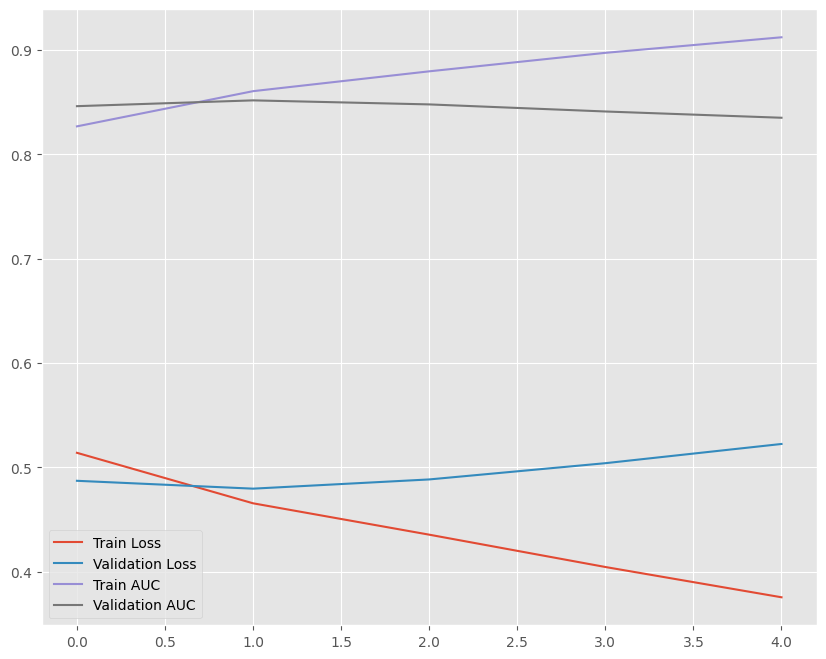

In [60]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()


In [61]:
# Evaluate the model on the validation dataset
val_metrics = model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)
val_auc_index = model.metrics_names.index('auc')
val_auc = val_metrics[val_auc_index]

print(f"Validation AUC: {val_auc:.4f}")

Validation AUC: 0.8343


In [62]:
rela_impr = ((val_auc - 0.5) / (auc_score_baseline1 - 0.5)) * 100
print(f"Relative Improvement (RelaImpr): {rela_impr:.2f}%")

Relative Improvement (RelaImpr): 100.53%


# Data Owner 2 with Global Model Weights 

In [63]:
import jax.numpy as jnp

def combine_weights(weights2, global_weights, alpha=0.5): #alpha to determine the mix between global and local weights
    """Combines two sets of weights by averaging."""
    global_weights_mix_2 = {}
    
    # Ensure the keys in both weight sets are identical
    assert set(weights2.keys()) == set(global_weights.keys()), "Weight sets have different structures"
    
    # Iterate through each layer's weights
    for key in weights2:
        layer_weights2 = weights2[key]
        layer_global_weights = global_weights[key]
        
        # Ensure each layer's weights have identical shapes
        assert layer_weights2.shape == layer_global_weights.shape, f"Layer {key} has different shapes"
        
        # Average the weights
        global_weights_mix_2[key] = (alpha * layer_weights2 + (1- alpha) * layer_global_weights)
    
    return global_weights_mix_2


In [64]:
global_weights_mix_2 = combine_weights(weights2, global_weights)

In [65]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df2)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df2[dense_cols].values, tf.float32),
        tf.cast(df2[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df2['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [66]:
embedding_sizes = [emb_count for emb_count in emb_counts]

# Model architecture parameters
embedding_dim = 2
arch_bot = [8, 2]  # Architecture for the bottom MLP (processing dense features)
arch_top = [128, 64, 2]  # Architecture for the top MLP (combining embeddings and processed dense features)

class DLRM(tf.keras.Model):
    def __init__(self, embedding_sizes, embedding_dim, arch_bot, arch_top, self_interaction):
        super(DLRM, self).__init__()
        self.emb = [tf.keras.layers.Embedding(size, embedding_dim) for size in embedding_sizes]
        self.bot_nn = MLP(arch_bot, out_activation='relu')
        self.top_nn = MLP(arch_top, out_activation='sigmoid')
        self.interaction_op = SecondOrderFeatureInteraction(self_interaction)

    def call(self, inputs):
        input_dense, input_cat = inputs
        emb_x = [E(x) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
        dense_x = self.bot_nn(input_dense)

        Z = self.interaction_op(emb_x + [dense_x])
        z = tf.concat([dense_x, Z], axis=1)
        p = self.top_nn(z)

        return p

# Initialize the model
model = DLRM(
    embedding_sizes=embedding_sizes,
    embedding_dim=embedding_dim,
    arch_bot=arch_bot,
    arch_top=arch_top,
    self_interaction=False
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', AUC(name='auc')]
)

# Generate dummy input to build the model
dummy_input_dense = tf.random.uniform((1, len(dense_cols)), dtype=tf.float32)
dummy_input_cat = tf.random.uniform((1, len(cat_cols)), maxval=2, dtype=tf.int32)
model([dummy_input_dense, dummy_input_cat])  # This builds the model's layers

# Set the pre-trained weights
for layer in model.layers:
    if hasattr(layer, 'layers'):  # For nested layers
        for sub_layer in layer.layers:
            if sub_layer.name in global_weights_mix_2:
                sub_layer.set_weights(global_weights_mix_2[sub_layer.name])
    else:
        if layer.name in global_weights_mix_2:
            layer.set_weights(global_weights_mix_2[layer.name])


In [67]:
BATCH_SIZE = 128

history =model.fit(
    ds_train.batch(BATCH_SIZE),
    validation_data=ds_valid.batch(BATCH_SIZE),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
    ],
    epochs=5,
    verbose=1,
)


Epoch 1/5
4265/4265 [==============================] - 46s 11ms/step - loss: 0.5093 - accuracy: 0.7634 - auc: 0.8295 - val_loss: 0.4796 - val_accuracy: 0.7756 - val_auc: 0.8513
Epoch 2/5
4265/4265 [==============================] - 45s 11ms/step - loss: 0.4634 - accuracy: 0.7839 - auc: 0.8624 - val_loss: 0.4754 - val_accuracy: 0.7778 - val_auc: 0.8545
Epoch 3/5
4265/4265 [==============================] - 60s 14ms/step - loss: 0.4347 - accuracy: 0.8006 - auc: 0.8804 - val_loss: 0.4859 - val_accuracy: 0.7738 - val_auc: 0.8494
Epoch 4/5
4265/4265 [==============================] - 62s 14ms/step - loss: 0.4047 - accuracy: 0.8178 - auc: 0.8975 - val_loss: 0.5059 - val_accuracy: 0.7651 - val_auc: 0.8409
Epoch 5/5
4265/4265 [==============================] - 56s 13ms/step - loss: 0.3766 - accuracy: 0.8327 - auc: 0.9119 - val_loss: 0.5279 - val_accuracy: 0.7606 - val_auc: 0.8327


In [68]:
model.summary()

Model: "dlrm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  2632      
                                                                 
 embedding_1 (Embedding)     multiple                  1066      
                                                                 
 embedding_2 (Embedding)     multiple                  849010    
                                                                 
 embedding_3 (Embedding)     multiple                  303040    
                                                                 
 embedding_4 (Embedding)     multiple                  558       
                                                                 
 embedding_5 (Embedding)     multiple                  32        
                                                                 
 embedding_6 (Embedding)     multiple                  22222  

In [69]:
results = model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

853/853 [==============================] - 3s 1ms/step - loss: 0.5391 - accuracy: 0.7549 - auc: 0.8273
Loss: 0.5390822291374207, Accuracy: 0.7549437284469604, AUC: 0.8272863030433655


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.509324,0.763407,0.829463,0.479637,0.775555,0.851251
1,0.463420,0.783911,0.862364,0.475416,0.777827,0.854528
2,0.434656,0.800580,0.880438,0.485913,0.773833,0.849438
3,0.404716,0.817755,0.897478,0.505890,0.765077,0.840899
4,0.376601,0.832725,0.911887,0.527946,0.760643,0.832743


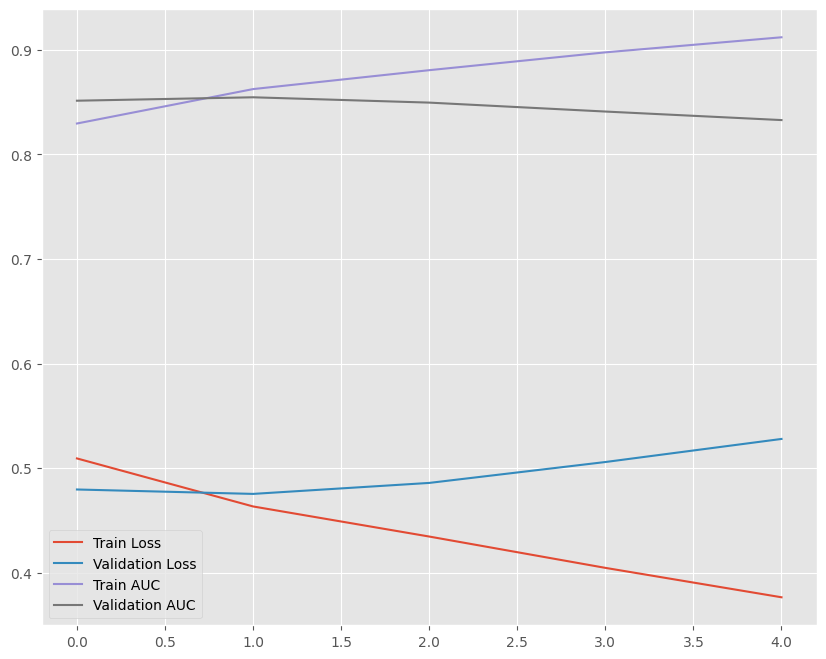

In [70]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()


In [71]:
# Evaluate the model on the validation dataset
val_metrics = model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)
val_auc_index = model.metrics_names.index('auc')
val_auc = val_metrics[val_auc_index]

print(f"Validation AUC: {val_auc:.4f}")


Validation AUC: 0.8329


In [72]:
rela_impr = ((val_auc - 0.5) / (auc_score_baseline2 - 0.5)) * 100
print(f"Relative Improvement (RelaImpr): {rela_impr:.2f}%")

Relative Improvement (RelaImpr): 100.98%
